# Cálculo del rizado y el tiempo de respuesta en un filtro RC para PWM

Queremos filtrar una señal PWM para obtener una señal analógica de voltaje variable. Lo más sencillo para conseguir este objetivo es utilizar un simple filtro RC de primer orden:

<img src="https://electronicbase.net/wp-content/uploads/rc-filter-circuit.png" alt="Filtro RC" width="400"/>

A continuación vamos a estudiar las características de este filtro, mostrando cómo ajustarlo para filtrar una señal PWM de forma óptima.

## Función de transferencia del filtro RC
La función de transferencia de un filtro RC de primer orden es la siguiente:

$$
H(s) = \frac{1}{1 + RCs}=\frac{1}{1 + \tau s}\implies H(\omega) = \frac{1}{1 + \tau j\omega}
$$

donde $\tau = RC$ es la *constante de tiempo* del filtro.

Se puede demostrar que la frecuencia de corte del filtro es:

$$
f_c = \frac{1}{2\pi\tau}
$$

La función de transferencia también se puede expresar en función de la frecuencia $f$, sabiendo que $\omega = 2\pi f$:

$$
H(f) = \frac{1}{1 + j\frac{f}{f_c}}
$$

Para estudiar la calidad del filtrado en señales PWM, nos interesa conocer la amplitud de la respuesta:

$$
\left|H(f)\right| = \frac{1}{\sqrt{1 + \left(\frac{f}{f_c}\right)^2}}
$$

## Filtrado de señal PWM
Los dos principales parámetros que definen la calidad de la señal filtrada son el rizado y el tiempo de respuesta:

 * El rizado es la diferencia entre los voltajes máximo y mínimo de la señal, cuando el *duty cycle* del PWM es constante.
 * El tiempo de respuesta es lo que tarda la señal filtrada en alcanzar el 90% del valor final, ante una entrada escalón.
 
El rizado viene determinado por la frecuencia del PWM y la frecuencia de corte del filtro, mientras que el tiempo de respuesta sólo depende de esta última. Así, para una frecuencia de PWM fija, bajar la frecuencia de corte tiene un efecto positivo (reduce el rizado) pero otro negativo (aumenta el tiempo de respuesta). Aumentar la frecuencia del PWM permite mejorar el rizado sin afectar al tiempo de respuesta, pero no siempre es posible. Hay microcontroladores, como el Arduino Uno, que no permiten modificarla (a no ser que se utilicen funciones de bajo nivel). Y además, frecuencias de PWM elevadas aumentan el consumo energético cuando se controlan transistores, porque éstos disipan más energía cuando trabajan en su zona lineal, y cada ciclo de PWM implica dos pasos por la misma.

### Cálculo del rizado
Normalmente el rizado se define para el PWM trabajando al 50%, ya que es el peor caso. Este valor se puede estimar usando la siguiente expresión:

$$
V_R \approx \frac{\pi}{2}\left|H\left(f_{PWM}\right)\right|V_{PWM}
$$

donde $f_{PWM}$ y $V_{PWM}$ son la frecuencia y la amplitud de la señal PWM, respectivamente.

### Cálculo del tiempo de respuesta
La respuesta del filtro tiene la forma:

$$
V(t) = V(0) e^{-\tau t}
$$

Por lo tanto, el tiempo de respuesta se puede calcular como:

$$
T_r = -RC\ln(1 - 0.9)
$$

## Ejemplo
A continuación de muestra en una gráfica la señal PWM de entrada, en color azul, junto a la señal obtenida tras el filtrado, en color naranja, para un PWM al 50% en régimen permanente. Se puede comprobar cómo cambia el resultado al variar los valores de $R$, $C$ o $f_{PWM}$.

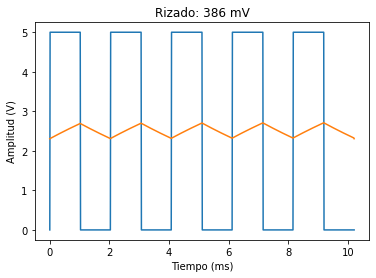

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

R = 2e4     # Resistencia en Ohm
C = 330e-9  # Condensador en F
F = 490.0   # Frecuencia del PWM en Hz (Arduino Uno: 490)
V = 5.0     # Voltaje del PWM en V     (Arduino Uno: 5)

# Frecuencia de corte
tau = R*C
fc = 1/(2*np.pi*tau)

# Función de transferencia (amplitud)
H = lambda f: 1/np.sqrt(1 + (f/fc)**2)
M = lambda f: 20*math.log10(H(f))

# Rizado al 50% de ciclo, en mV
r50 = 0.5*math.pi*abs(H(F))*V*1e3

# Tiempo de respuesta hasta 90%, en ms
t90 = -tau*math.log(1 - 0.9)*1e3

# Respuesta en régimen permanente
nc = 5          # Número de ciclos en la gráfica
nd = 1000       # Número de divisiones (resolución)
h = nc/F/nd     # Paso de tiempo

t = np.linspace(0, h*nd, nd + 1)
y = np.zeros(nd + 1) + 0.5*V - 0.0005*r50
u = np.zeros(nd + 1)

for i in range(1, nd):
    if i%(nd/nc) <= 0.5*nd/nc:
        u[i] = V
    y[i] = tau/(tau + h)*y[i - 1] + h/(tau + h)*u[i]

plt.plot(1e3*t, u, 1e3*t, y)
plt.title("Rizado: %0.0f mV" % r50)
plt.xlabel("Tiempo (ms)")
plt.ylabel("Amplitud (V)");

Para ilustrar el efecto de $T_r$, en la siguiente gráfica se muestra la respuesta a una entrada escalón del 100% (el PWM pasa repentinamente de 0 a 100% en el instante inicial). El tiempo de resupesta es el que tarda la señal filtrada (en color naranja) en alcanzar el 90% de $V_{PWM}$. En este caso no existe rizado, ya que al estar el PWM al 100%, la señal de entrada es constante.

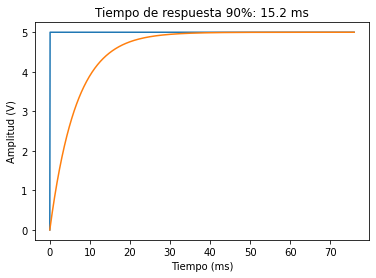

In [2]:
# Respuesta transitoria (entrada escalón)
t = np.linspace(0, 5*t90*1e-3, nd + 1)
u = np.append(0, np.ones(nd)*V)
y = map(lambda x: V*(1 - math.exp(-x/tau)), t)

plt.plot(1e3*t, u, 1e3*t, list(y))
plt.title("Tiempo de respuesta 90%%: %0.1f ms" % t90)
plt.xlabel("Tiempo (ms)")
plt.ylabel("Amplitud (V)");

Por último, se muestra la respuesta en frecuencia del filtro:

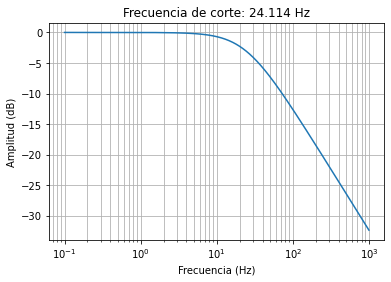

In [3]:
# Respuesta en frecuencia
fr = np.logspace(-1, 3, 1000)

plt.semilogx(fr, list(map(M, fr)))
plt.title("Frecuencia de corte: %0.3f Hz" % fc)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud (dB)")
plt.grid(which = "both")